In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Callable, Union, Dict, Literal, Optional, Tuple, List

from data.mri.data_loader import get_dataset
from utils.makepath import makepath as mkp
from encoding_objects.cart_2d_enc_obj import Cart2DEncObj
from pdhg.pdhg import TvPdhgTorch, TgvPdhgTorch
from gradops.gradops_torch import GradOpsTorch
from utils.metrics import ImageMetricsEvaluator
from utils.mask_funcs import cartesian_mask
from utils.noise_functions import add_gaussian_noise
from scripts.mri.test_utils import save_as_image

# Config and Data

In [3]:
# device = "cpu"
device = "cuda"

In [4]:
root_dir = mkp("..", "..")

In [5]:
config = get_prepared_config(model_id="u_tv", root_dir=root_dir)

Config loaded from file ../../tmp/mri_model_09_14-14_37-good_TV-sigma_to_0_2-R_from_4/config.yaml


In [6]:
data_config = config["data"]

In [7]:
acceleration_factor_R = 8
gaussian_noise_standard_deviation_sigma = 0.05

In [8]:
test_dataset = get_dataset(
    action="test",
    data_config=data_config,
    device=device,
    acceleration_factor_R=acceleration_factor_R,
    gaussian_noise_standard_deviation_sigma=gaussian_noise_standard_deviation_sigma
)



Ground truth data shape: torch.Size([302, 320, 320])
min abs val of ground truth: 1.8633207901075366e-06
max abs val of ground truth: 1.385725498199463

Corrupted data shape: torch.Size([302, 320, 320])
min abs val of corrupted: 2.1736816506745527e-06
max abs val of corrupted: 1.1920750141143799

Corrupted kdata shape: torch.Size([302, 1, 320, 320])

kmasks shape: torch.Size([302, 320, 320])



In [9]:
data_util = GeneralDataUtil(device=device)

In [10]:
enc_obj = Cart2DEncObj()

In [11]:
sample_idx = 0

sample = test_dataset[sample_idx]
x_corrupted, x_true, \
    kdata_corrupted, undersampling_kmask = sample

x_corrupted = x_corrupted.unsqueeze(0)
x_true = x_true.unsqueeze(0)
kdata_corrupted = kdata_corrupted.unsqueeze(0)
undersampling_kmask = undersampling_kmask.unsqueeze(0)

num_iters = 256

In [12]:
print(f"x_corrupted.shape: {x_corrupted.shape}")
print(f"x_true.shape: {x_true.shape}")
print(f"kdata_corrupted.shape: {kdata_corrupted.shape}")
print(f"undersampling_kmask.shape: {undersampling_kmask.shape}")

x_corrupted.shape: torch.Size([1, 320, 320])
x_true.shape: torch.Size([1, 320, 320])
kdata_corrupted.shape: torch.Size([1, 1, 320, 320])
undersampling_kmask.shape: torch.Size([1, 320, 320])


# Test

In [13]:
enc_obj.apply_AH(
    k=kdata_corrupted, csm=None,
    mask=undersampling_kmask).shape

torch.Size([1, 320, 320])

In [14]:
enc_obj.apply_A(
    x=x_corrupted, csm=None,
    mask=undersampling_kmask).shape

torch.Size([1, 1, 320, 320])

In [15]:
def prepare_lambda(
        lambda_reg: Union[float, torch.Tensor],
        domain: Literal["V", "W"]) -> torch.Tensor:
    """
    Parameters
    ----------
    lambda_reg : float or torch.Tensor.
            If tensor then assume lambda_reg in U (same shape as image)
    domain : str
            Either "V" or "W" to indicate which domain the
            regularisation should be applied to
            (V for gradient, W for symmetrised gradient)

    >>> tgv_pdhg_solver = TgvPdhgTorch(sigma=8.7, tau=0.01, device="cpu")
    >>> x = torch.zeros(10, 10, 2).cpu()
    >>> lambda_reg = 0.0  # Should handle zero divided by zero
    >>> proj = tgv_pdhg_solver.P_alpha(x, lambda_reg, domain="V")
    >>> proj.shape
    torch.Size([10, 10, 2])
    >>> torch.isnan(proj).any().cpu().item()
    >>> # Should handle pixel value zero divided by lambda_reg value zero.
    >>> # Zero lambda_reg means no regularisation,
    >>> # so pixel zero remains the same.
    False
    >>> type(lambda_reg)
    <class 'float'>
    >>> lambda_reg = torch.rand(10, 10).cpu()
    >>> proj = tgv_pdhg_solver.P_alpha(x, lambda_reg, domain="V")
    >>> proj.shape
    torch.Size([10, 10, 2])
    >>> torch.isnan(proj).any().cpu().item()
    False
    >>> lambda_reg.shape # lambda_reg should be unchanged
    torch.Size([10, 10])
    """
    if not isinstance(lambda_reg, torch.Tensor):
        assert isinstance(lambda_reg, float), \
            f"Expected float, got {type(lambda_reg)}"
        # Make a 2D tensor
        lambda_reg = torch.full(
                size=(1, 1, 1), fill_value=lambda_reg, device=device)
    assert lambda_reg.ndim == 3, \
        "Expected 3 dimensions (batch_size, Nx, Ny). " + \
        f"Got {lambda_reg.ndim}: {lambda_reg.shape}"
    lambda_reg = lambda_reg.to(device)
    if domain == "V":
        lambda_reg = lambda_reg.unsqueeze(-1)
    elif domain == "W":
        lambda_reg = lambda_reg.unsqueeze(-1).unsqueeze(-1)
    else:
        raise ValueError(
            f"Unknown domain. Expected 'V' or 'W', got {domain}")
    # Add another dimension for when viewing as real
    lambda_reg = lambda_reg.unsqueeze(-1)
    return lambda_reg

def clip_lambda(
        x: torch.Tensor, lambda_reg: torch.Tensor) -> torch.Tensor:
    if x.is_complex():
        x = torch.view_as_real(x)
        clipped_x = torch.clamp(x, -lambda_reg, lambda_reg)
        return torch.view_as_complex(clipped_x)
    return torch.clamp(x, -lambda_reg, lambda_reg)

def prepare_variable(
        x: torch.Tensor, shape: torch.Size,
        default_value: Optional[Union[float, torch.Tensor]] = 0.0,
        dtype: Optional[torch.dtype] = None) -> torch.Tensor:
    if x is None:
        zeros = torch.zeros(shape, dtype=dtype).to(device)
        if not isinstance(default_value, torch.Tensor):
            default_value = torch.tensor(default_value)
        default_value = default_value.to(device)
        x = zeros + default_value
    return x.to(device)

def get_variables(
        state: Union[torch.Tensor, Dict[
            Literal["x", "v", "p", "q", "r", "x_bar", "v_bar"],
            torch.Tensor]],
        var_names: Tuple[str]) -> List[Union[torch.Tensor, None]]:
    variables = []
    for var_name in var_names:
        if isinstance(state, dict):
            variables.append(state.get(var_name, None))
        else:
            variables.append(None)
    return variables

In [16]:
def run_pdhg(
        iterator,  # determines how long to run algorithm for
        A: Callable, AH: Callable,
        lambda_reg: Union[float, torch.Tensor],
        z: torch.Tensor,  # measured data
        state: Union[torch.Tensor, Dict[
            Literal["x", "v", "p", "r", "x_bar"], torch.Tensor]],
        sigma: Union[float, torch.Tensor],
        tau: Union[float, torch.Tensor],
        theta: Union[float, torch.Tensor],
        return_dict: bool = False
) -> Union[torch.Tensor, Dict[
        Literal["x", "v", "p", "r", "x_bar"], torch.Tensor]]:
    """
    Adapted from Algorithm 2 from
    'Learning Regularization Parameter-Maps for Variational
    Image Reconstruction using Deep Neural Networks and
    Algorithm Unrolling', 2023,
    by Andreas Kofler et al.
    """
    if isinstance(state, dict):
        x = state["x"]  # initial image estimate
    elif isinstance(state, torch.Tensor):
        x = state   # initial image estimate
    else:
        raise ValueError(
            "Unknown input type. " +
            f"Expected dict or torch.Tensor, got {type(state)}")

    x = x.to(device)
    z = z.to(device)
    v, p, r, x_bar = get_variables(state, ("v", "p", "r", "x_bar"))
    # matches the shape of the gradient [n, n, 2]
    v = prepare_variable(
        v, shape=x.shape + (2,), dtype=x.dtype)
    # match the shape of the symmetrised gradient [n, n, 2, 2]
    p = prepare_variable(
        p, shape=x.shape + (2,), dtype=x.dtype)
    # match the shape of the measured data
    r = prepare_variable(
        r, shape=z.shape, dtype=x.dtype)
    x_bar = prepare_variable(
        x_bar, shape=x.shape, default_value=x, dtype=x.dtype)

    lambda_reg = prepare_lambda(lambda_reg, domain="V")
    assert torch.view_as_real(p).ndim == lambda_reg.ndim, \
        f"Expected {torch.view_as_real(p).ndim}. Got {lambda_reg.ndim}"

    g = GradOpsTorch()

    for _ in iterator:
        p = p + sigma * g.nabla_h(x_bar)
        p = clip_lambda(p, lambda_reg)   # projection operator

        r = r + sigma * (A(x_bar) - z)
        r = r / (1.0 + sigma)   # proximal operator

        # NOTE: The plus and minus signs are opposite to the paper.
        # If we switch any of the signs, the algorithm will not work.
        x_next = x + tau * (g.div_h_v(p) - AH(r))
        x_bar = x_next + theta * (x_next - x)
        x = x_next

        with torch.no_grad():
            torch.cuda.empty_cache()

    if return_dict:
        return {
            "x": x, "z": z, "v": v, "p": p, "r": r,
            "x_bar": x_bar, "device": device}
    return x

In [17]:
def A(x: torch.Tensor) -> torch.Tensor:
    return enc_obj.apply_A(x=x, csm=None, mask=undersampling_kmask)

def AH(k: torch.Tensor) -> torch.Tensor:
    return enc_obj.apply_AH(k=k, csm=None, mask=undersampling_kmask)

In [18]:
x_reconstructed = run_pdhg(
    iterator=tqdm(range(num_iters)),
    A=A, AH=AH,
    lambda_reg=0.1,
    # kdata=kdata_corrupted,
    z=kdata_corrupted,
    # kmask=undersampling_kmask,
    state=x_corrupted,
    # csmap=None,
    sigma=1.0/3, tau=1.0/3, theta=1,
    return_dict=False,
    # tqdm_progress_bar=tqdm
)

  0%|          | 0/256 [00:00<?, ?it/s]

In [19]:
tv_pdhg_solver = TvPdhgTorch(device=device)

x_reconstructed = tv_pdhg_solver.run_pdhg(
    iterator=tqdm(range(num_iters)),
    A=A, AH=AH,
    lambda_reg=0.1,
    # kdata=kdata_corrupted,
    z=kdata_corrupted,
    # kmask=undersampling_kmask,
    state=x_corrupted,
    # csmap=None,
    sigma=1.0/3, tau=1.0/3, theta=1,
    return_dict=False,
    # tqdm_progress_bar=tqdm
)

  0%|          | 0/256 [00:00<?, ?it/s]

In [20]:
tgv_pdhg_solver = TgvPdhgTorch(device=device)

x_reconstructed = tgv_pdhg_solver.run_pdhg(
    iterator=tqdm(range(num_iters)),
    A=A, AH=AH,
    lambda_reg={
        "lambda1_v": 0.1, "lambda0_w": 0.1
    },
    # kdata=kdata_corrupted,
    z=kdata_corrupted,
    # kmask=undersampling_kmask,
    state=x_corrupted,
    # csmap=None,
    sigma=1.0/3, tau=1.0/3, theta=1,
    return_dict=False,
    # tqdm_progress_bar=tqdm
)

  0%|          | 0/256 [00:00<?, ?it/s]

# Setup

In [21]:
complex_to_real_conversion = "view_as_real"
# complex_to_real_conversion = "abs"

metrics_evaluator = ImageMetricsEvaluator(
    complex_to_real_conversion=complex_to_real_conversion,
    device=device
)

# regularisation = "tv"
regularisation = "tgv"

if regularisation == "tv":
    end = 0.2
    step = 0.001
    n_steps = int(end / step) + 1
    print(f"n_steps: {n_steps}")
    lambda_search_space = tqdm(np.linspace(0, end, n_steps), desc="lambda")
    pdhg_solver = TvPdhgTorch(device=device)
    columns = ["lambda", "psnr", "ssim"]
    filename = f"tv_grid_search-{complex_to_real_conversion}-lambda_end_{end}_step_{step}".replace(".", "_") + ".csv"
elif regularisation == "tgv":
    end_1_v = 0.2
    end_0_w = 0.2
    step_1_v = 0.01
    step_0_w = 0.01
    # Best for abs:          0.01,0.02,25.653505325317383,0.7204217314720154
    # Best for view_as_real: 0.01,0.02,32.780914306640625,0.7431737184524536
    n_steps_1_v = int(end_1_v / step_1_v) + 1
    n_steps_0_w = int(end_0_w / step_0_w) + 1
    print(f"n_steps_1_v: {n_steps_1_v}")
    print(f"n_steps_0_w: {n_steps_0_w}")
    lambda_search_space = []
    for lambda1_v in tqdm(np.linspace(0, end_1_v, n_steps_1_v), desc="lambd1_v"):
        for lambda0_w in np.linspace(0, end_0_w, n_steps_0_w):
            lambda_search_space.append(
                {"lambda1_v": lambda1_v, "lambda0_w": lambda0_w}
            )
    lambda_search_space = tqdm(lambda_search_space, desc="lambda")
    pdhg_solver = TgvPdhgTorch(device=device)
    columns = ["lambda1_v", "lambda0_w", "psnr", "ssim"]
    filename = f"tgv_grid_search-{complex_to_real_conversion}-lambda1_v_end_{end_1_v}_step_{step_1_v}-lambda0_w_end_{end_0_w}_step_{step_0_w}".replace(".", "_") + ".csv"

print(f"NOTE: Chosen regularisation: {regularisation}")
print(f"type(pdhg_solver): {type(pdhg_solver)}")

NOTE: Complex-to-real conversion method: view_as_real
n_steps_1_v: 21
n_steps_0_w: 21


lambd1_v:   0%|          | 0/21 [00:00<?, ?it/s]

lambda:   0%|          | 0/441 [00:00<?, ?it/s]

NOTE: Chosen regularisation: tgv
type(pdhg_solver): <class 'pdhg.pdhg.TgvPdhgTorch'>


# Run Grid Search

In [22]:
# df = pd.DataFrame()

# for lambda_reg in lambda_search_space:
#     x_reconstructed = pdhg_solver.run_pdhg(
#         # iterator=tqdm(range(num_iters)),
#         iterator=range(num_iters),
#         A=A, AH=AH,
#         lambda_reg=lambda_reg,
#         # kdata=kdata_corrupted,
#         z=kdata_corrupted,
#         # kmask=undersampling_kmask,
#         state=x_corrupted,
#         # csmap=None,
#         sigma=1.0/3, tau=1.0/3, theta=1,
#         return_dict=False,
#         # tqdm_progress_bar=tqdm
#     )
#     psnr, ssim = metrics_evaluator.compute_torch(
#         x=x_reconstructed,
#         x_true=x_true
#     )
#     if regularisation == "tv":
#         data = [[lambda_reg, psnr.item(), ssim.item()]]
#     elif regularisation == "tgv":
#         data = [[lambda_reg["lambda1_v"], lambda_reg["lambda0_w"], psnr.item(), ssim.item()]]
#     df = pd.concat(
#         [df, pd.DataFrame(data=data, columns=columns)],
#         ignore_index=True
#     )

In [23]:
# df.head()

# Save Results

In [24]:
results_path = mkp(
    ".",
    "results",
    f"sample_{sample_idx}",
    f"R_{acceleration_factor_R}-sigma_{gaussian_noise_standard_deviation_sigma}".replace(".", "_"),
    f"T_{num_iters}"
)

In [25]:
os.makedirs(results_path, exist_ok=True)

In [26]:
# df.to_csv(mkp(results_path, filename), index=False)

# Get the best result and reconstruct the image

In [27]:
filename

'tgv_grid_search-view_as_real-lambda1_v_end_0_2_step_0_01-lambda0_w_end_0_2_step_0_01.csv'

In [28]:
# regularisation = "tv"
regularisation = "tgv"
complex_to_real_conversion = "abs"
metrics_evaluator = ImageMetricsEvaluator(
    complex_to_real_conversion=complex_to_real_conversion,
    device=device
)
df = pd.read_csv(mkp(
    results_path,
    # filename
    # "tv_grid_search-view_as_real-lambda_end_0_4_step_0_001.csv"
    # "tv_grid_search-abs-lambda_end_0_2_step_0_001.csv"
    "tgv_grid_search-abs-lambda1_v_end_0_2_step_0_01-lambda0_w_end_0_2_step_0_01.csv"
))

NOTE: Complex-to-real conversion method: abs


In [29]:
df['psnr'].idxmax()

23

In [30]:
best_psnr = df.iloc[df['psnr'].idxmax()]
best_psnr

lambda1_v     0.010000
lambda0_w     0.020000
psnr         25.653505
ssim          0.720422
Name: 23, dtype: float64

In [31]:
if regularisation == "tv":
    best_lambda_reg = best_psnr["lambda"]
elif regularisation == "tgv":
    best_lambda_reg = {
        "lambda1_v": best_psnr["lambda1_v"],
        "lambda0_w": best_psnr["lambda0_w"]
    }
best_lambda_reg

{'lambda1_v': 0.01, 'lambda0_w': 0.02}

In [32]:
if regularisation == "tv":
    pdhg_solver = TvPdhgTorch(device=device)
elif regularisation == "tgv":
    pdhg_solver = TgvPdhgTorch(device=device)
x_reconstructed = pdhg_solver.run_pdhg(
    iterator=tqdm(range(num_iters)),
    A=A, AH=AH,
    lambda_reg=best_lambda_reg,
    z=kdata_corrupted,
    state=x_corrupted,
    sigma=1.0/3, tau=1.0/3, theta=1,
    return_dict=False
)

  0%|          | 0/256 [00:00<?, ?it/s]

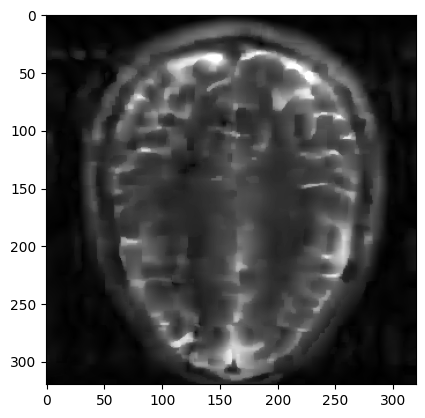

In [34]:
x_reconstructed_abs = torch.abs(x_reconstructed[0])
x_reconstructed_abs_np = x_reconstructed_abs.detach().cpu().numpy()
plt.imshow(x_reconstructed_abs_np, cmap="gray", clim=(0, 0.5))

In [244]:
if regularisation == "tv":
    save_as_image(
        sample_idx=sample_idx,
        batch_complex=x_reconstructed.unsqueeze(0),
        image_name=f"tv-lambda_{best_lambda_reg}".replace(".", "_"),
        batch_x_true=x_true.unsqueeze(0),
        acc_factor_R=acceleration_factor_R,
        gaussian_noise_sigma=gaussian_noise_standard_deviation_sigma,
        num_iters=256,
        clip_range=(0, 0.5),
        metrics_evaluator=metrics_evaluator,
        out_dir=results_path)
elif regularisation == "tgv":
    save_as_image(
        sample_idx=sample_idx,
        batch_complex=x_reconstructed.unsqueeze(0),
        image_name=f"tgv-lambda1_v_{best_lambda_reg['lambda1_v']}-lambda0_w_{best_lambda_reg['lambda0_w']}".replace(".", "_"),
        batch_x_true=x_true.unsqueeze(0),
        acc_factor_R=acceleration_factor_R,
        gaussian_noise_sigma=gaussian_noise_standard_deviation_sigma,
        num_iters=256,
        clip_range=(0, 0.5),
        metrics_evaluator=metrics_evaluator,
        out_dir=results_path)

Saving tgv-lambda1_v_0_01-lambda0_w_0_02 image
abs - tgv-lambda1_v_0_01-lambda0_w_0_02 metrics: PSNR = 25.65, SSIM = 0.7204


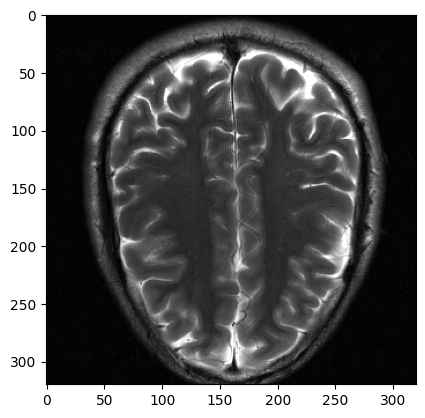

In [161]:
x_true_abs = torch.abs(x_true)
x_true_abs_np = x_true_abs.detach().cpu().numpy()
plt.imshow(x_true_abs_np, cmap="gray", clim=(0, 0.5))

In [162]:
# load some ground-truth data (currently assumed to be in the same folder)
# path = os.getcwd()
slice_id = 0  # only one slice for xtrue_example.pt
mri_data_dir = mkp(root_dir, "tmp", "mri_data")
xtrue_example_path = mkp(mri_data_dir, "x_true_example.pt")
x_true_example = torch.load(xtrue_example_path, map_location=device)[[slice_id], ...]
print(f"x_true_example shape: {x_true_example.shape}")
x_true_example = x_true_example[0] * 1000
print(f"x_true_example shape: {x_true_example.shape}")
print(f"x_true_example.dtype: {x_true_example.dtype}")
print(f"x_true_example.device: {x_true_example.device}")

x_true_example shape: torch.Size([1, 320, 320])
x_true_example shape: torch.Size([320, 320])
x_true_example.dtype: torch.complex64
x_true_example.device: cuda:0


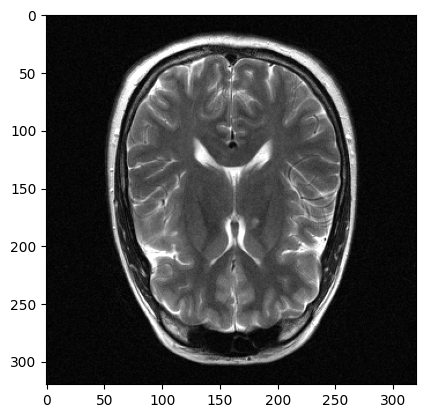

In [163]:
x_true_example_abs = torch.abs(x_true_example)
x_true_example_abs_np = x_true_example_abs.detach().cpu().numpy()
plt.imshow(x_true_example_abs_np, cmap="gray", clim=(0, 0.5))

In [188]:
def complex_number_x_true_to_kdata(
        x_true: torch.Tensor, R: int, noise_var: float
) -> torch.Tensor:
    # define the "encoding object" that contains the forward and the adjoint
    # of the MRI acquisition operator
    EncObj = Cart2DEncObj()

    undersampling_kmask = cartesian_mask(x_true.shape, acc=R).to(device)

    # retrospectively generate k-space data from the ground-truth image
    csm = None  # no coil sensitity maps used here --> single coil
    undersampled_kdata = EncObj.apply_A(x_true, csm, undersampling_kmask).to(device)

    # add noise to it
    undersampled_kdata_noisy, noise_for_undersampled_kdata = add_gaussian_noise(
        undersampled_kdata, undersampling_kmask, noise_var=noise_var)

    undersampled_kdata_noisy = undersampled_kdata_noisy.to(device)

    x_corrupted = EncObj.apply_AH(
        k=undersampled_kdata_noisy, csm=csm, mask=undersampling_kmask).to(device)

    return x_corrupted, undersampled_kdata_noisy, undersampling_kmask

batch_x_true_example = x_true_example.unsqueeze(0)
batch_x_corrupted_example, batch_kdata_corrupted_example, batch_undersampling_kmask_example = \
    complex_number_x_true_to_kdata(
        batch_x_true_example,
        # R=acceleration_factor_R,
        # noise_var=gaussian_noise_standard_deviation_sigma ** 2
        # R=4,
        R=2,
        noise_var=0.01
    )
print(f"batch_x_corrupted_example.device: {batch_x_corrupted_example.device}")
print(f"batch_kdata_corrupted_example.device: {batch_kdata_corrupted_example.device}")
print(f"batch_undersampling_kmask_example.device: {batch_undersampling_kmask_example.device}")

batch_x_corrupted_example.device: cuda:0
batch_kdata_corrupted_example.device: cuda:0
batch_undersampling_kmask_example.device: cuda:0


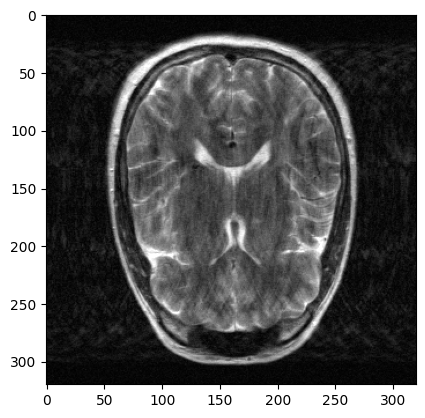

In [189]:
x_corrupted_example_abs = torch.abs(batch_x_corrupted_example[0])
x_corrupted_example_abs_np = x_corrupted_example_abs.detach().cpu().numpy()
plt.imshow(x_corrupted_example_abs_np, cmap="gray", clim=(0, 0.5))

In [198]:
batch_x_reconstructed_example = tv_pdhg_solver.run_pdhg(
    iterator=tqdm(range(num_iters)),
    A=lambda x: enc_obj.apply_A(
        x=x, csm=None, mask=batch_undersampling_kmask_example),
    AH=lambda k: enc_obj.apply_AH(
        k=k, csm=None, mask=batch_undersampling_kmask_example),
    lambda_reg=0.01,
    z=batch_kdata_corrupted_example,
    state=batch_x_corrupted_example,
    sigma=1.0/3, tau=1.0/3, theta=1,
    return_dict=False
)

  0%|          | 0/256 [00:00<?, ?it/s]

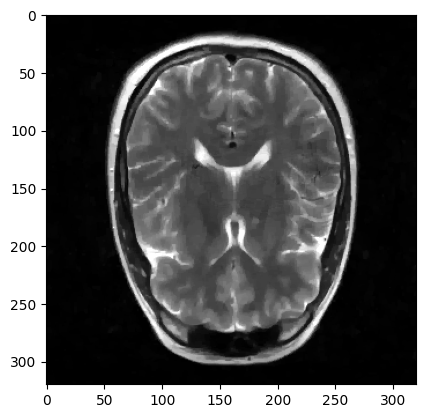

In [199]:
x_reconstructed_example_abs = torch.abs(batch_x_reconstructed_example[0])
x_reconstructed_example_abs_np = x_reconstructed_example_abs.detach().cpu().numpy()
plt.imshow(x_reconstructed_example_abs_np, cmap="gray", clim=(0, 0.5))

In [192]:
EncObj = Cart2DEncObj()

from networks.grad_ops import GradOperators
GradOps = GradOperators(
    dim=2, mode="forward",
    padmode="reflect"
)

def pdhg(
        nu, x0, y, sigma, tau, theta, lambda_reg, A, AH, G, GH,
        device, return_state=False):
    from networks.prox_ops import clipact

    """
        implemented according to
        https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf, algorithm 4
        """
    # workaround for mixed complex/real addcmul
    # for pytorch <= 1.13 compatibility
    if y.is_complex():
        addcmul = lambda x1, x2, x3: torch.view_as_complex(torch.addcmul(
            torch.view_as_real(x1), torch.view_as_real(x2), x3))
    else:
        addcmul = torch.addcmul

    x0 = x0.to(device)
    y = y.to(device)

    if isinstance(x0, dict):
        p, q, xbar, x1 = x0["p"], x0["q"], x0["xbar"], x0["x1"]
    else:
        p = torch.zeros(y.shape, dtype=y.dtype, device=device)
        q = torch.zeros(
            x0.shape[0], 2, *x0.shape[1:], dtype=x0.dtype,
            device=device)
        xbar = x0
        x1 = x0

    def to_tensor(x):
        if not torch.is_tensor(x):
            x = torch.tensor(x)
        x = x.to(device)
        return x

    sigma = to_tensor(sigma)
    tau = to_tensor(tau)
    theta = to_tensor(theta)

    for ku in range(nu):
        A_xbar = A(xbar).to(device)
        p = addcmul(p, A_xbar - y, sigma)
        p = p * (1 / (1 + sigma))
        G_xbar = G(xbar).to(device)
        q = addcmul(q, G_xbar, sigma)
        q = clipact(q, lambda_reg)
        AH_p = AH(p).to(device)
        GH_q = GH(q).to(device)
        step = AH_p + GH_q
        x1 = addcmul(x1, step, -tau)
        xbar = addcmul(x1, step, -tau * theta)

    # f = x0
    # iterator = range(nu)
    # for i in iterator:
    #     # update p
    #     # p = (p + tau * (A(u_bar) - f)) / (tau + 1.0)
    #     p = (p + tau * (A(xbar) - f)) / (tau + 1.0)
    #     # update q
    #     # q = self.P_lambda(q + tau * self.nabla_h(u_bar))
    #     q = clipact(q + tau * G(xbar), lambda_reg)

    #     # u_next = u - sigma * AH(p) + sigma * self.div_h_v(q)
    #     x1 = x0 - sigma * AH(p) + sigma * GH(q)

    #     # u_bar = u_next + theta * (u_next - u)
    #     xbar = x1 + theta * (x1 - x0)

    #     # u = u_next
    #     x0 = x1

    #     # with torch.no_grad():
    #     #     torch.cuda.empty_cache()

    if return_state:
        return x1, {"p": p, "q": q, "xbar": xbar, "x1": x1}
    return x1

In [193]:
batch_x_reconstructed_example_2 = pdhg(
    nu=256, # number of iterations
    x0=batch_x_corrupted_example,
    y=batch_kdata_corrupted_example,
    tau=1.0/3,
    sigma=1.0/3,
    theta=1,
    lambda_reg=torch.Tensor([0.01]),
        A = lambda x: EncObj.apply_A(
            x, None, batch_undersampling_kmask_example.to("cpu")),
        AH = lambda x: EncObj.apply_AH(
            x, None, batch_undersampling_kmask_example.to("cpu")),
    G=GradOps.apply_G,
    GH=GradOps.apply_GH,
    device="cpu",
    return_state=False,
)

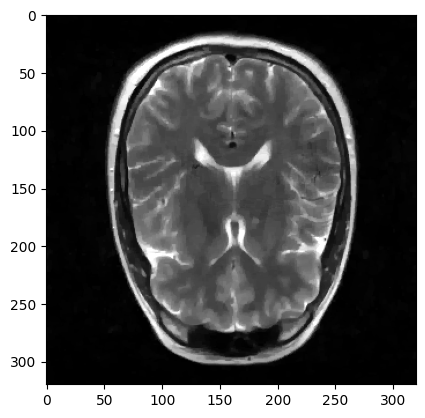

In [194]:
x_reconstructed_example_2_abs = torch.abs(batch_x_reconstructed_example_2[0])
x_reconstructed_example_2_abs_np = x_reconstructed_example_2_abs.detach().cpu().numpy()
plt.imshow(x_reconstructed_example_2_abs_np, cmap="gray", clim=(0, 0.5))

In [195]:
print(f"Min: {torch.min(x_reconstructed_example_2_abs)}")
print(f"Max: {torch.max(x_reconstructed_example_2_abs)}")

Min: 3.2279342121910304e-05
Max: 0.6554462313652039


In [197]:
print(f"batch_x_corrupted_example min: {torch.min(batch_x_corrupted_example.abs())}")
print(f"batch_x_corrupted_example max: {torch.max(batch_x_corrupted_example.abs())}")

print(f"batch_kdata_corrupted_example min: {torch.min(batch_kdata_corrupted_example.abs())}")
print(f"batch_kdata_corrupted_example max: {torch.max(batch_kdata_corrupted_example.abs())}")

batch_x_corrupted_example min: 0.00017218243738170713
batch_x_corrupted_example max: 0.6200017333030701
batch_kdata_corrupted_example min: 0.0
batch_kdata_corrupted_example max: 22.648820877075195


In [202]:
batch_x_reconstructed_2 = pdhg(
    nu=256, # number of iterations
    x0=x_corrupted.unsqueeze(0),
    y=kdata_corrupted.unsqueeze(0),
    tau=1.0/3,
    sigma=1.0/3,
    theta=1,
    lambda_reg=torch.Tensor([0.008]),
        A = lambda x: EncObj.apply_A(
            x, None, undersampling_kmask.unsqueeze(0).to("cpu")),
        AH = lambda x: EncObj.apply_AH(
            x, None, undersampling_kmask.unsqueeze(0).to("cpu")),
    G=GradOps.apply_G,
    GH=GradOps.apply_GH,
    device="cpu",
    return_state=False,
)

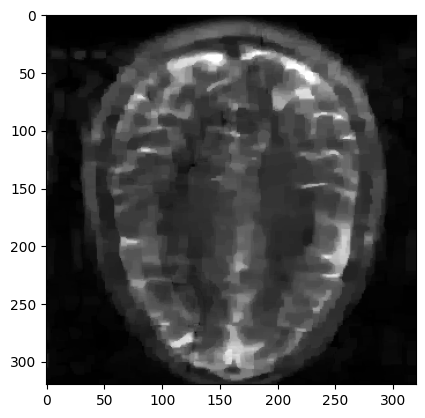

In [203]:
x_reconstructed_2_abs = torch.abs(batch_x_reconstructed_2[0])
x_reconstructed_2_abs_np = x_reconstructed_2_abs.detach().cpu().numpy()
plt.imshow(x_reconstructed_2_abs_np, cmap="gray", clim=(0, 0.5))

In [205]:
x_reconstructed_tv = tv_pdhg_solver.run_pdhg(
    iterator=tqdm(range(num_iters)),
    A=A, AH=AH,
    lambda_reg=0.008,
    z=kdata_corrupted,
    state=x_corrupted,
    sigma=1.0/3, tau=1.0/3, theta=1,
    return_dict=False
)

  0%|          | 0/256 [00:00<?, ?it/s]

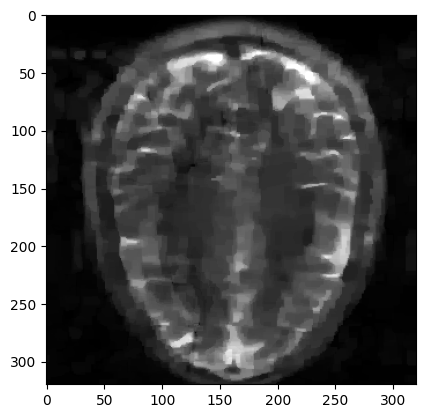

In [206]:
x_reconstructed_tv_abs = torch.abs(x_reconstructed_tv)
x_reconstructed_tv_abs_np = x_reconstructed_tv_abs.detach().cpu().numpy()
plt.imshow(x_reconstructed_tv_abs_np, cmap="gray", clim=(0, 0.5))

  0%|          | 0/256 [00:00<?, ?it/s]

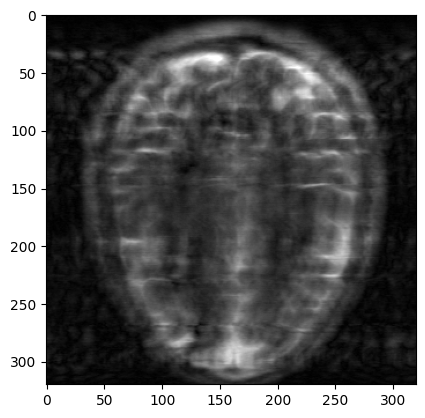

lambda_scalar: 0.0, psnr: 31.15261459350586, ssim: 0.6636826992034912


  0%|          | 0/256 [00:00<?, ?it/s]

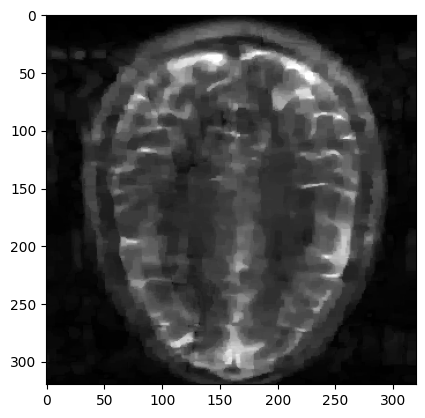

lambda_scalar: 0.004, psnr: 32.36258316040039, ssim: 0.7366651296615601


  0%|          | 0/256 [00:00<?, ?it/s]

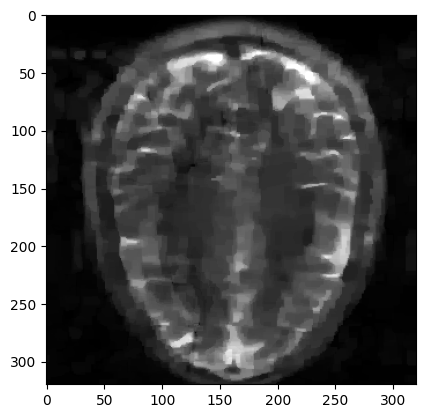

lambda_scalar: 0.008, psnr: 32.57107925415039, ssim: 0.7685515880584717


  0%|          | 0/256 [00:00<?, ?it/s]

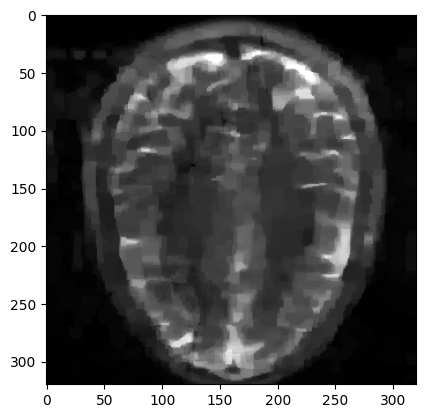

lambda_scalar: 0.012, psnr: 32.537776947021484, ssim: 0.780548095703125


  0%|          | 0/256 [00:00<?, ?it/s]

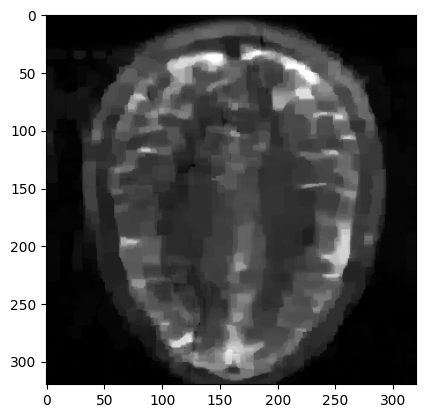

lambda_scalar: 0.02, psnr: 32.33527755737305, ssim: 0.7853609323501587


  0%|          | 0/256 [00:00<?, ?it/s]

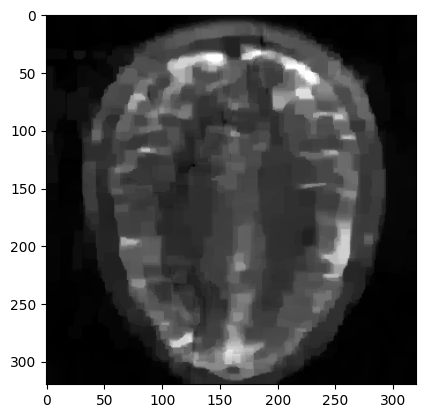

lambda_scalar: 0.03, psnr: 32.0748405456543, ssim: 0.7833752036094666


  0%|          | 0/256 [00:00<?, ?it/s]

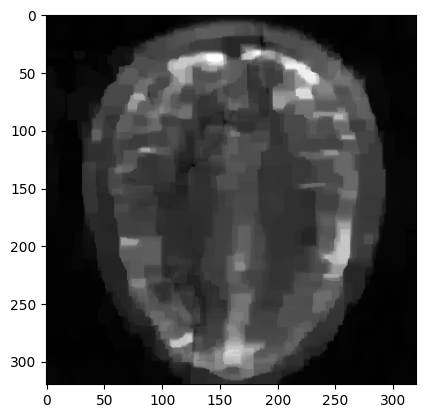

lambda_scalar: 0.05, psnr: 31.650997161865234, ssim: 0.7756932377815247


  0%|          | 0/256 [00:00<?, ?it/s]

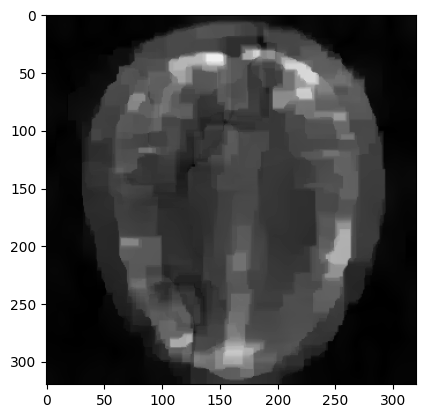

lambda_scalar: 0.1, psnr: 30.879928588867188, ssim: 0.7523346543312073


  0%|          | 0/256 [00:00<?, ?it/s]

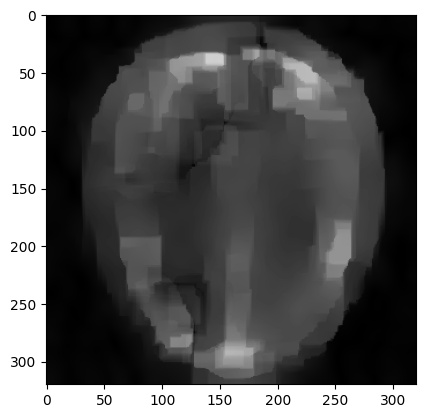

lambda_scalar: 0.2, psnr: 29.937946319580078, ssim: 0.7196981310844421


  0%|          | 0/256 [00:00<?, ?it/s]

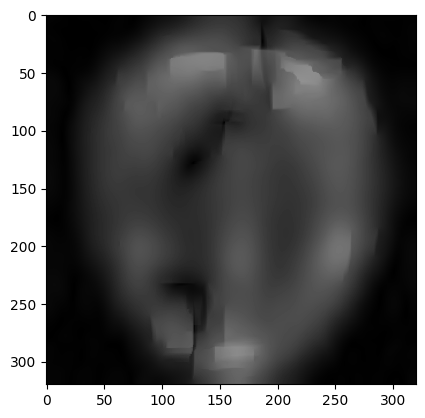

lambda_scalar: 0.5, psnr: 28.560344696044922, ssim: 0.678176760673523


In [209]:
for lambda_scalar in [0.0, 0.004, 0.008, 0.012, 0.02, 0.03, 0.05, 0.1, 0.2, 0.5]:
    x_reconstructed_tv = tv_pdhg_solver.run_pdhg(
        iterator=tqdm(range(num_iters)),
        A=A, AH=AH,
        lambda_reg=lambda_scalar,
        z=kdata_corrupted,
        state=x_corrupted,
        sigma=1.0/3, tau=1.0/3, theta=1,
        return_dict=False
    )

    x_reconstructed_tv_abs = torch.abs(x_reconstructed_tv)
    x_reconstructed_tv_abs_np = x_reconstructed_tv_abs.detach().cpu().numpy()
    plt.imshow(x_reconstructed_tv_abs_np, cmap="gray", clim=(0, 0.5))
    plt.show()

    psnr, ssim = metrics_evaluator.compute_torch(
        x=x_reconstructed_tv,
        x_true=x_true
    )
    print(f"lambda_scalar: {lambda_scalar}, psnr: {psnr}, ssim: {ssim}")